# Tune the meta model
 
We want to check if we can exchange the metamodel from Ridge to DNN

We use the best base model parameters from the previous notebooks

# Model v4.1 - Baseline model with MA02 DNN as base estimator

In [1]:
from fileinput import filename

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.version_utils import callbacks

from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [3]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [5]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Predict for validation data and check results

Pretrain with train data
Epoch 1/100
8934/8934 - 25s - 3ms/step - loss: 7.3403 - rmse: 2.5408 - val_loss: 4.5590 - val_rmse: 2.1064
Epoch 2/100
8934/8934 - 24s - 3ms/step - loss: 4.9337 - rmse: 2.1909 - val_loss: 4.3924 - val_rmse: 2.0689
Epoch 3/100
8934/8934 - 22s - 2ms/step - loss: 4.7356 - rmse: 2.1466 - val_loss: 4.3343 - val_rmse: 2.0556
Epoch 4/100
8934/8934 - 21s - 2ms/step - loss: 4.5955 - rmse: 2.1145 - val_loss: 4.2397 - val_rmse: 2.0304
Epoch 5/100
8934/8934 - 28s - 3ms/step - loss: 4.4958 - rmse: 2.0919 - val_loss: 4.2931 - val_rmse: 2.0445
Epoch 6/100
8934/8934 - 22s - 3ms/step - loss: 4.4244 - rmse: 2.0749 - val_loss: 4.1513 - val_rmse: 2.0082
Epoch 7/100
8934/8934 - 26s - 3ms/step - loss: 4.3531 - rmse: 2.0575 - val_loss: 4.1301 - val_rmse: 2.0034
Epoch 8/100
8934/8934 - 31s - 3ms/step - loss: 4.3052 - rmse: 2.0460 - val_loss: 4.1732 - val_rmse: 2.0160
Epoch 9/100
8934/8934 - 28s - 3ms/step - loss: 4.2619 - rmse: 2.0350 - val_loss: 4.0908 - val_rmse: 1.9907
Epoch 10/100

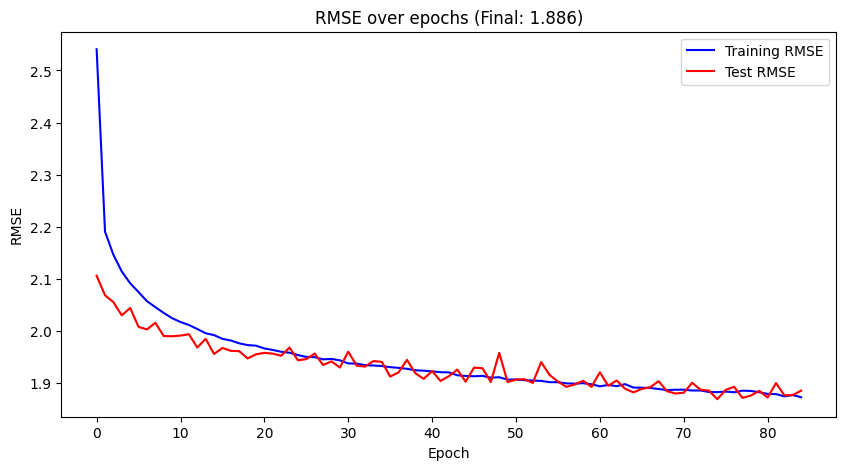

In [6]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from model_performance_calculations import get_history_line_chart


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        # Input layer
        Input(shape=(input_dimension,)),

        # First dense block
        Dense(512, activation='relu'),  # Increased neurons
        BatchNormalization(),
        Dropout(0.3),  # Slightly reduced dropout for better capacity

        # Second dense block
        Dense(256, activation='relu'),  # Increased neurons
        BatchNormalization(),
        Dropout(0.3),

        # Third dense block
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Fourth dense block (new)
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='linear')  # Regression output
    ])

    # Compile the model
    dnn.compile(
        optimizer=Adam(learning_rate=0.001),  # Retained learning rate
        loss='mse',  # Mean Squared Error for regression
        metrics=[rmse]  # Custom RMSE metric
    )

    return dnn


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights('v4.1-MA02.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(optimizer='adam', loss='mse', metrics=[rmse])
    return dnn


pretrained_dnn = create_dnn_model(X_train.shape[1])

X_additional_train, X_additional_val, y_additional_train, y_additional_val = train_test_split(
    X_additional_train, y_additional_train, random_state=42, test_size=0.2, shuffle=True)

print('Pretrain with train data')
pretrained_dnn.fit(
    pd.concat([X_train, X_additional_train], axis=0),
    pd.concat([y_train, y_additional_train], axis=0),
    validation_data=(X_additional_val, y_additional_val),
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_rmse', patience=10, restore_best_weights=True, mode='min')],
    epochs=100,
    verbose=2
)

history = pretrained_dnn.history.history

print('Pretrain with Validation Data')
pretrained_dnn.fit(
    X_additional_val,
    y_additional_val,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)],
    verbose=2
)

print('Pretrain save weights')
pretrained_dnn.save_weights('v4.1-MA02.weights.h5')
get_history_line_chart([history]).show()

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge

hgb_estimator = HistGradientBoostingRegressor(max_iter=200, max_depth=5, learning_rate=0.1)
lasso_lars_ic_base_model = LassoLarsIC(criterion='bic', max_iter=10000)
knn_base_model = KNeighborsRegressor(n_neighbors=5)
xgb_base_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=5, learning_rate=0.1)

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_model),
    ('xgb', xgb_base_model),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

13:57:02 - Start training
13:57:02 - Calculate performance for hgb
13:57:02 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
13:57:02 - Split 1 - Model: hgb
13:57:02 - Fitting the model
13:57:10 - Predicting
13:57:10 - Calculating scores
13:57:10 - R^2: 0.6050453409101859, RMSE: 2.0466277078439625, MAE: 1.5297522075223886, MSE: 4.188684974514633
13:57:10 - Split 2 - Model: hgb
13:57:10 - Fitting the model
13:57:17 - Predicting
13:57:17 - Calculating scores
13:57:17 - R^2: 0.6103539170299525, RMSE: 2.0353684728679102, MAE: 1.5196817963995308, MSE: 4.142724820344649
13:57:17 - Split 3 - Model: hgb
13:57:17 - Fitting the model
13:57:24 - Predicting
13:57:24 - Calculating scores
13:57:24 - R^2: 0.6038911957599782, RMSE: 2.045449827689371, MAE: 1.5294409588963966, MSE: 4.183864997594477
13:57:24 - Split 4 - Model: hgb
13:57:24 - Fitting the model
13:57:31 - Predicting
13:57:31 - Calculating scores
13:57:31 - R^2: 0.6109547820358057, RMSE: 2.0267

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 6s - 731us/step - loss: 3.4375 - rmse: 3.7242
13:58:44 - Predicting
843/843 - 1s - 667us/step
13:58:45 - Calculating scores
13:58:45 - R^2: 0.6867674425686964, RMSE: 1.8226306822666214, MAE: 1.3849448049028674, MSE: 3.32198260393969
13:58:45 - Split 2 - Model: dnn
13:58:45 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 6s - 711us/step - loss: 3.4391 - rmse: 3.7227
13:58:51 - Predicting
843/843 - 1s - 796us/step
13:58:52 - Calculating scores
13:58:52 - R^2: 0.6891171941706795, RMSE: 1.8180517341739884, MAE: 1.379359210855729, MSE: 3.3053121081330468
13:58:52 - Split 3 - Model: dnn
13:58:52 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 5s - 660us/step - loss: 3.4319 - rmse: 3.7256
13:58:57 - Predicting
843/843 - 1s - 627us/step
13:58:58 - Calculating scores
13:58:58 - R^2: 0.6828010974853079, RMSE: 1.8304059612817558, MAE: 1.3921486740143416, MSE: 3.350385983095789
13:58:58 - Split 4 - Model: dnn
13:58:58 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 5s - 634us/step - loss: 3.4308 - rmse: 3.7241
13:59:03 - Predicting
843/843 - 1s - 680us/step
13:59:04 - Calculating scores
13:59:04 - R^2: 0.6889258041467431, RMSE: 1.8123025013509324, MAE: 1.3759986242841753, MSE: 3.2844403564028464
13:59:04 - Split 5 - Model: dnn
13:59:04 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 5s - 618us/step - loss: 3.4428 - rmse: 3.7216
13:59:09 - Predicting
843/843 - 1s - 646us/step
13:59:10 - Calculating scores
13:59:10 - R^2: 0.6877803535353225, RMSE: 1.8203382326490622, MAE: 1.382766681410079, MSE: 3.3136312812439117
13:59:10 - Training finished
13:59:10 - Calculate performance for final_estimator
13:59:10 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
13:59:10 - Split 1 - Model: final_estimator
13:59:10 - Fitting the model
13:59:10 - Predicting
13:59:10 - Calculating scores
13:59:10 - R^2: 0.5416336603327585, RMSE: 2.204812119703481, MAE: 1.6578682976489942, MSE: 4.861196483191357
13:59:10 - Split 2 - Model: final_estimator
13:59:10 - Fitting the model
13:59:10 - Predicting
13:59:10 - Calculating scores
13:59:10 - R^2: 0.5447389574809235, RMSE: 2.2000782625240527, MAE: 1.6590599141697953, MSE: 4.840344361230854
13:59:10 - Split 3 - Model: final_estimator
13:59:10 - Fitting the model
13:59:11 - Predicting
13:5

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 6s - 749us/step - loss: 3.4507 - rmse: 3.7266


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 651us/step - loss: 3.3127 - rmse: 3.7492
1619/1619 - 1s - 654us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 666us/step - loss: 3.5827 - rmse: 3.7706
1619/1619 - 1s - 577us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 614us/step - loss: 3.5246 - rmse: 3.7457
1619/1619 - 1s - 548us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 5s - 814us/step - loss: 3.4005 - rmse: 3.6653
1619/1619 - 1s - 621us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 687us/step - loss: 3.3581 - rmse: 3.6706
1619/1619 - 1s - 664us/step
14:01:47 - Predicting
843/843 - 1s - 647us/step
14:01:55 - Calculating scores
14:01:55 - R^2: 0.708701344255717, RMSE: 1.7576583796629652, MAE: 1.3068294295160836, MSE: 3.08936297959944
14:01:55 - Split 2 - Model: stacking_regressor
14:01:55 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 5s - 671us/step - loss: 3.4358 - rmse: 3.7208


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 5s - 701us/step - loss: 3.3146 - rmse: 3.7489
1619/1619 - 1s - 551us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 611us/step - loss: 3.5911 - rmse: 3.7736
1619/1619 - 1s - 620us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 650us/step - loss: 3.5129 - rmse: 3.7420
1619/1619 - 1s - 542us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 691us/step - loss: 3.3855 - rmse: 3.6650
1619/1619 - 1s - 652us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 613us/step - loss: 3.3828 - rmse: 3.6691
1619/1619 - 1s - 545us/step
14:04:32 - Predicting
843/843 - 1s - 616us/step
14:04:40 - Calculating scores
14:04:40 - R^2: 0.7093372761792117, RMSE: 1.7579339573466204, MAE: 1.3043881800553179, MSE: 3.0903317983923495
14:04:40 - Split 3 - Model: stacking_regressor
14:04:40 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 5s - 603us/step - loss: 3.4370 - rmse: 3.7248


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 618us/step - loss: 3.3102 - rmse: 3.7469
1619/1619 - 1s - 553us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 613us/step - loss: 3.5833 - rmse: 3.7732
1619/1619 - 1s - 546us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 605us/step - loss: 3.5255 - rmse: 3.7507
1619/1619 - 1s - 547us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 620us/step - loss: 3.3708 - rmse: 3.6660
1619/1619 - 1s - 559us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 615us/step - loss: 3.3818 - rmse: 3.6664
1619/1619 - 1s - 650us/step
14:07:10 - Predicting
843/843 - 1s - 594us/step
14:07:17 - Calculating scores
14:07:17 - R^2: 0.7047574249049545, RMSE: 1.765920205742313, MAE: 1.3148994241064753, MSE: 3.118474173048973
14:07:17 - Split 4 - Model: stacking_regressor
14:07:17 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 5s - 604us/step - loss: 3.4440 - rmse: 3.7240


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 636us/step - loss: 3.3115 - rmse: 3.7497
1619/1619 - 1s - 767us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 643us/step - loss: 3.5964 - rmse: 3.7719
1619/1619 - 1s - 595us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 606us/step - loss: 3.5270 - rmse: 3.7469
1619/1619 - 1s - 588us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 652us/step - loss: 3.3835 - rmse: 3.6651
1619/1619 - 1s - 569us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 653us/step - loss: 3.3838 - rmse: 3.6689
1619/1619 - 1s - 600us/step
14:09:47 - Predicting
843/843 - 1s - 633us/step
14:09:54 - Calculating scores
14:09:54 - R^2: 0.7081679620006491, RMSE: 1.7553558878454798, MAE: 1.2971415324675104, MSE: 3.081274292993793
14:09:54 - Split 5 - Model: stacking_regressor
14:09:54 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8091/8091 - 5s - 604us/step - loss: 3.4284 - rmse: 3.7196


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 638us/step - loss: 3.3368 - rmse: 3.7482
1619/1619 - 1s - 563us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 638us/step - loss: 3.5872 - rmse: 3.7762
1619/1619 - 1s - 546us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 598us/step - loss: 3.5270 - rmse: 3.7434
1619/1619 - 1s - 584us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 4s - 598us/step - loss: 3.3743 - rmse: 3.6688
1619/1619 - 1s - 541us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


6473/6473 - 5s - 699us/step - loss: 3.3667 - rmse: 3.6641
1619/1619 - 1s - 653us/step
14:12:24 - Predicting
843/843 - 1s - 604us/step
14:12:32 - Calculating scores
14:12:32 - R^2: 0.7098059424698029, RMSE: 1.754956007901104, MAE: 1.3034629281943713, MSE: 3.0798705896681793
14:12:32 - Training finished
Final estimator RMSE: 1.7583648876996965
Final estimator R2: 0.708153989962067
Final estimator MSE: 3.091862766740547
Final estimator MAE: 1.3053442988679518


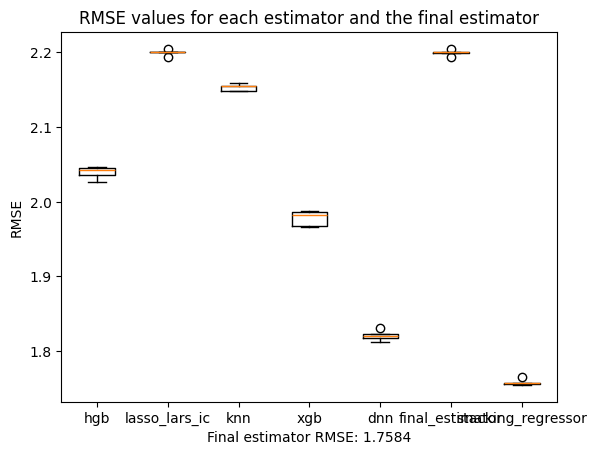

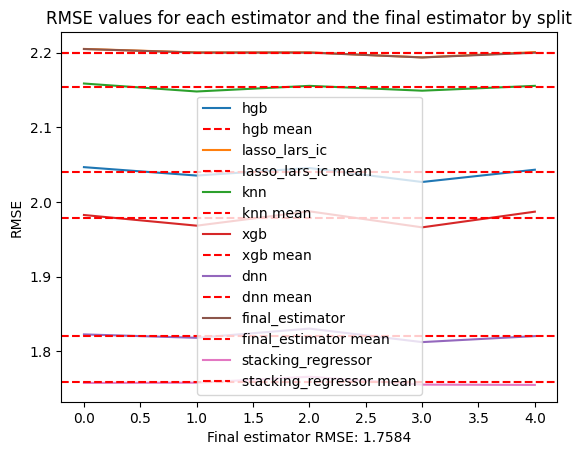

In [8]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-v4.1-DNN'

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_additional_train, y_additional_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

In [9]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))

X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']
X_test = pipeline.transform(test_data)

model.fit(X_train, y_train)

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


9987/9987 - 6s - 559us/step - loss: 3.5339 - rmse: 3.7668


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 597us/step - loss: 3.4616 - rmse: 3.8214
1998/1998 - 1s - 533us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 626us/step - loss: 3.6425 - rmse: 3.8015
1998/1998 - 1s - 549us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 620us/step - loss: 3.4696 - rmse: 3.7551
1998/1998 - 1s - 539us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 602us/step - loss: 3.5916 - rmse: 3.7531
1998/1998 - 1s - 538us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 631us/step - loss: 3.4585 - rmse: 3.6875
1998/1998 - 1s - 544us/step


StackingRegressor(estimators=[('hgb',
                               HistGradientBoostingRegressor(max_depth=5,
                                                             max_iter=200)),
                              ('lasso_lars_ic',
                               LassoLarsIC(criterion='bic', max_iter=10000)),
                              ('knn', KNeighborsRegressor()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('dnn',
                               KerasRegressor(model=<function model_with_pretrained_weights at 0x13fedd1c0>, verbose=2))],
                  final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

In [10]:
y_pred = model.predict(X_test)
test_data['bg+1:00'] = y_pred

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

114/114 - 0s - 1ms/step


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.471742
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,6.218301
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.204001
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.741727
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.544298


In [11]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission.to_csv(f'submission-{model_name}.csv')
submission

,bg+1:00
id,
p01_8459,8.471742
p01_8460,6.218301
p01_8461,8.204001
p01_8462,11.741727
p01_8463,8.544298
...,...
p24_256,6.468439
p24_257,11.090163
p24_258,6.414386


In [12]:
submission.describe()

,bg+1:00
count,3644.000000
mean,8.628790
std,2.616127
min,3.152206
25%,6.791981
50%,8.041023
75%,9.752140
max,24.815644
